* https://docs.pymc.io/notebooks/GP-Marginal.html#Example:-Regression-with-white,-Gaussian-noise

<br>

# Preliminaries

In [1]:
!rm -rf *sh

<br>

**Packages**

In [2]:
import subprocess

In [3]:
if 'google.colab' in str(get_ipython()):
    subprocess.run('wget -q https://raw.githubusercontent.com/plausibilities/fundamentals/develop/scripts.sh', shell=True)
    subprocess.run('chmod u+x scripts.sh', shell=True)
    subprocess.run('./scripts.sh', shell=True)

<br>

**Paths**

In [4]:
import os
import pathlib
import sys

In [5]:
if not 'google.colab' in str(get_ipython()):
    
    notebooks = os.path.split(os.getcwd())[0]
    parent = str(pathlib.Path(notebooks).parent.parent)
    sys.path.append(parent)

<br>

**Libraries**

In [6]:
%matplotlib inline

In [7]:
import arviz as az
import graphviz
import pymc3 as pm

import logging
import collections

import numpy as np
import pandas as pd
import scipy as sp

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import theano

In [8]:
pm.__version__

'3.9.3'

<br>

Custom

In [9]:
import fundamentals.graphics.settings
import fundamentals.graphics.relational

<br>

**General Instances**

A relational graph instance, and its labels class

In [10]:
relational = fundamentals.graphics.relational.Relational()

RelationalGraphLabels = collections.namedtuple(
    typename='RelationalGraphLabels', field_names=['title', 'xlabel', 'ylabel'])

<br>

## Set-up

<br>

**Display**

If the display screen supports **retina display**, a figure's resolution can be enhanced via

In [11]:
%config InlineBackend.figure_format = 'retina'

<br>

**Aesthetics**

In [12]:
settings = fundamentals.graphics.settings.Settings()

settings.layout()
settings.aesthetics()

<br>

**Seeds**

In [13]:
np.random.seed(seed=1)

<br>

## Logging

In [14]:
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

<br>
<br>

# Data

This study considers a problem wherein the observed data $\mathbf{y}$ is the sum of (a) a Gaussian Process $F$, and (b) and Gaussian Noise $\mathcal{E}$, i.e.,

* $\mathbf{y} = F + \mathcal{E}$

Each item is a $\small{N \times 1}$ vector, and the elements of $F$ are

* $F = f_{1}, f_{2}, \ldots, f_{n}, \ldots, f_{N}$

whereby

* $f_{n} = f(x_{n})$

<br>

## Simulating a process

The simulation of a Gaussian Process requires the specification of a **covariance function**.  This study opts for the, Matérn Covariance, i.e., [Matérn Kernel](https://en.wikipedia.org/wiki/Matérn_covariance_function#Simplification_for_specific_values_of_ν)

* $\eta^{2} * \small{pymc3.gp.cov.Matern52}()$

wherein

* $\small{pymc3.gp.cov.Matern52}()$ $= \left( 1 + \large{\frac{5^{^{\small{0.5}}}\delta}{l}} + \large{\frac{5 \delta^{2}}{3l^{2}}} \right) exp\left( -\large{\frac{5^{^{\small{0.5}}}\delta}{l}} \right)$

* $\delta = x - x'$

The variable $\delta$ denotes the distance between two points, and $\small{pymc3.gp.cov.Matern52}()$ is the [PyMC3 Matérn form](https://docs.pymc.io/api/gp/cov.html#pymc3.gp.cov.Matern52).  Hence, considering a column vector of inputs

In [15]:
N = 100
X = np.linspace(start=0, stop=10, num=N)[:, None]

<br>

let the true covariance function for this study be

In [16]:
ℓ_true = 1.0
η_true = 3.0
cov_func = (η_true**2) * pm.gp.cov.Matern52(input_dim=1, ls=ℓ_true)

<br>

therefore

In [17]:
logger.info('\n{}\n'.format(type(cov_func(X).eval()))) 
logger.info('\n{}\n'.format(cov_func(X).eval().shape)) 

INFO:__main__:
<class 'numpy.ndarray'>

INFO:__main__:
(100, 100)



<br>

The **true mean function**

In [18]:
mean_func = pm.gp.mean.Zero()

logger.info('\n{}\n'.format(type(mean_func(X).eval())))
logger.info('\n{}\n'.format(mean_func(X).eval().shape))

INFO:__main__:
<class 'numpy.ndarray'>

INFO:__main__:
(100,)



<br>

The **latent function** 

A latent function is a function whose underlying values are hidden, i.e., unobserved (ref. Pattern Recognition & Machine Learning, Chapter 8).  Herein, [*the latent function values are one sample from a multivariate normal*](https://docs.pymc.io/notebooks/GP-Marginal.html#Example:-Regression-with-white,-Gaussian-noise). $\;$   The $.eval()$ methods are due to the dependence on Theano.

In [19]:
f_true = np.random.multivariate_normal(mean_func(X).eval(),
                                       cov_func(X).eval() + 1e-8*np.eye(N), 1).flatten()

logger.info('\n{}\n'.format(type(f_true)))
logger.info('\n{}\n'.format(f_true.shape))

INFO:__main__:
<class 'numpy.ndarray'>

INFO:__main__:
(100,)



<br>

The **observed data**

Let the observed data be the sum of the **latent function** &  **independent and identically distributed Gaussian Noise**.  If the standard deviation of the noise is `sigma`, and noting that

* np.random.randn(N) is a $\small{N \times 1}$ vector

Then

In [20]:
σ_true = 2.0
y = f_true + (σ_true * np.random.randn(N))

logger.info('\n{}\n'.format(type(y)))
logger.info('\n{}\n'.format(y.shape))

INFO:__main__:
<class 'numpy.ndarray'>

INFO:__main__:
(100,)



<br>

## Illustrate

* [.plot](https://matplotlib.org/3.3.1/api/_as_gen/matplotlib.pyplot.plot.html#matplotlib.pyplot.plot) <br> https://matplotlib.org/3.2.0/api/axes_api.html#axis-labels-title-and-legend



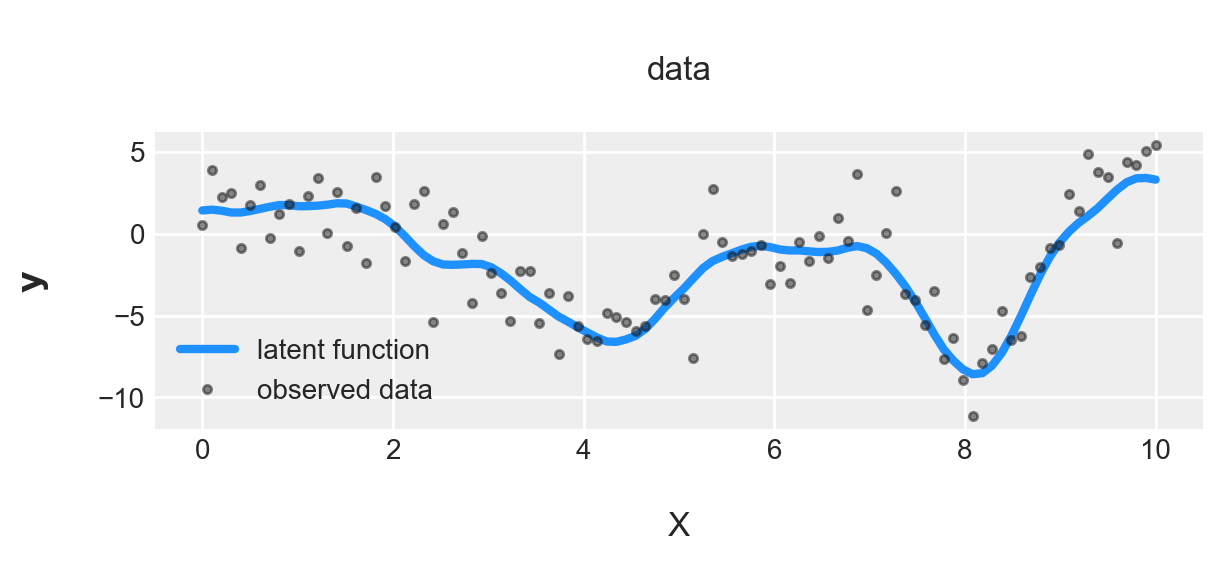

In [48]:
ax = relational.figure(width=6.0, height=2.7)

ax.plot(X, f_true, 'dodgerblue', linewidth=3, label='latent function');
ax.plot(X, y, 'ok', markersize=3, alpha=0.5, label='observed data');

relational.annotation(handle=ax, 
                      labels=RelationalGraphLabels._make(['\ndata\n', '\nX', r'$\mathbf{y}$' + '\n']))

ax.legend(loc='lower left', fontsize='small');


<br>
<br>

# Modelling


## Marginal Likelihood

Let the marginal distribution $p(\mathbf{y})$ conditioned on the input values $X = x_{1}, x_{2}, \ldots, x_{N}$ be

* $p(\mathbf{y}) = \mathcal{N}(\mathbf{y} | \mathbf{0}, C)$

wherein $C$ is the covariance matrix.  Let $f(x)$ be modelled as a Gaussian Process

* $f(x) \sim \mathcal{GP}\left(m(x), \: k(x, x')\right)$

and let the noise be modelled by

* $\mathcal{E} \sim \mathcal{N}(\mathbf{0}, \: \Sigma)$

In [22]:
with pm.Model() as model:

    # Specify a covariance function: https://docs.pymc.io/api/gp/cov.html
    # Initialise the parameters ℓ, η
    ℓ = pm.Gamma('ℓ', alpha=2, beta=1)
    η = pm.HalfCauchy('η', beta=5)
    cov = η**2 * pm.gp.cov.Matern52(1, ℓ)

    # Specify the Gaussian Process (GP); the default mean function is `Zero`.
    gp = pm.gp.Marginal(cov_func=cov, mean_func=pm.gp.mean.Zero())
    
    # Place a GP prior over the function f
    # The scale of the white noise term can be provided,
    σ = pm.HalfCauchy('σ', beta=5)
    y_ = gp.marginal_likelihood(name='y', X=X, y=y, noise=σ)

    # Inference!
    # draw 3000 posterior samples using NUTS sampling
    trace = pm.sample(draws=3000, cores=2, tune=2000)

    # The marginal [maximum] posteriors
    # Note: parameter model is optional if .find_MAP() is within context
    # ref. https://docs.pymc.io/api/inference.html
    maximal = pm.find_MAP()

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, η, ℓ]
INFO:pymc3:NUTS: [σ, η, ℓ]


Sampling 2 chains for 2_000 tune and 3_000 draw iterations (4_000 + 6_000 draws total) took 215 seconds.
INFO:pymc3:Sampling 2 chains for 2_000 tune and 3_000 draw iterations (4_000 + 6_000 draws total) took 215 seconds.
The acceptance probability does not match the target. It is 0.7118199371743146, but should be close to 0.8. Try to increase the number of tuning steps.


<br>

**DAG**

* Pattern Recognition & Machine Learning, Chapter 8

* Either  `pm.model_to_graphviz(model=model)`  or the approach below, which can be understood via the references <br> https://www.graphviz.org/doc/info/attrs.html <br> https://graphviz.readthedocs.io/en/stable/manual.html

In [23]:
# The DAG
diagram = pm.model_graph.ModelGraph(model=model).make_graph()
diagram.node_attr.update(shape='circle')
diagram.save('gp.gv')

'gp.gv'

In [24]:
graphviz.render(engine='dot', format='pdf', filepath='gp.gv')

'gp.gv.pdf'

<br>

**Trace**

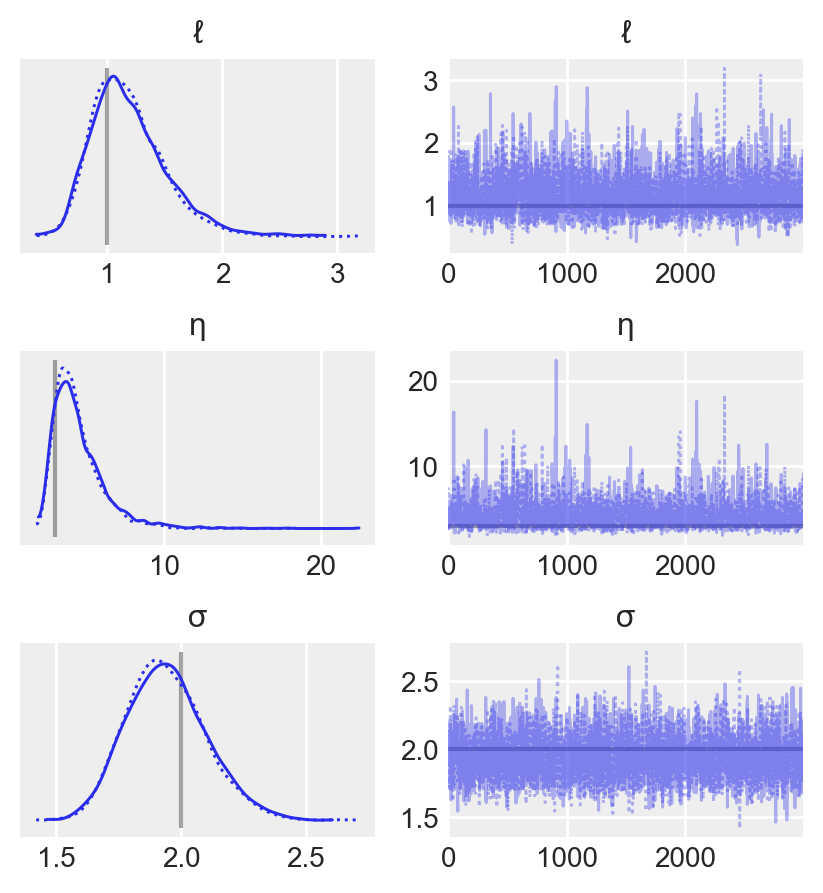

In [25]:
with model:
    pm.traceplot(data=trace, figsize=(4.00, 4.35), var_names=['ℓ', 'η', 'σ'], 
                 lines=[('ℓ', {}, ℓ_true), ('η', {}, η_true), ('σ', {}, σ_true)])


<br>

And

In [26]:
pd.DataFrame(data={'lambda': trace.get_values(varname='ℓ'), 'eta': trace.get_values(varname='η'), 'sigma': trace.get_values(varname='σ')}).head()

,lambda,eta,sigma
0,1.364640,4.876175,1.897605
1,0.783670,2.942446,1.934549
2,0.779670,2.726871,1.938608
3,0.787220,4.045327,2.001429
4,1.050294,3.750119,2.008860


In [27]:
logger.info('\n{}\n'.format(trace.get_values(varname='ℓ').shape))

INFO:__main__:
(6000,)



<br>

## Maximum a posteriori

In [28]:
maximal

{'ℓ_log__': array(0.00460842),
 'η_log__': array(1.24959788),
 'σ_log__': array(0.64421439),
 'ℓ': array(1.00461906),
 'η': array(3.4889397),
 'σ': array(1.90449025)}

In [29]:
pd.DataFrame({'Parameter': ['ℓ', 'η', 'σ'],
              'Value at MAP': [float(maximal['ℓ']), float(maximal['η']), float(maximal['σ'])],
              'True value': [ℓ_true, η_true, σ_true]})

,Parameter,Value at MAP,True value
0,ℓ,1.004619,1.0
1,η,3.488940,3.0
2,σ,1.904490,2.0


<br>
<br>

# Predicting

In [30]:
X_new = np.linspace(0, 20, 600)[:, None]

<br>

## via *.conditional( )*

If `pred_noise=False` the conditional method will produce a predictive distribution of the underlying function via the `gp` model. Whereas, if `pred_noise=True`, observation noise is included in the conditional.  Predictions via

* maximum a posteriori, or
* a trace set, e.g., 

In [31]:
samplings = trace.report.n_draws * trace.nchains
indices = np.random.randint(low=0, high=samplings, size=100)

<br>

### Case: MAP, excl. Noise

* pred_samples = pm.sample_posterior_predictive([mp], vars=[f_pred], samples=2000, model=model)

In [32]:
with model:
    f_pred = gp.conditional('f_predictions', X_new)
    pred_samples = pm.sample_posterior_predictive([maximal], vars=[f_pred], samples=2000)
    
logger.info('\n{}\n'.format(pred_samples['f_predictions'].shape))

INFO:__main__:
(2000, 600)



<br>

* illustrate

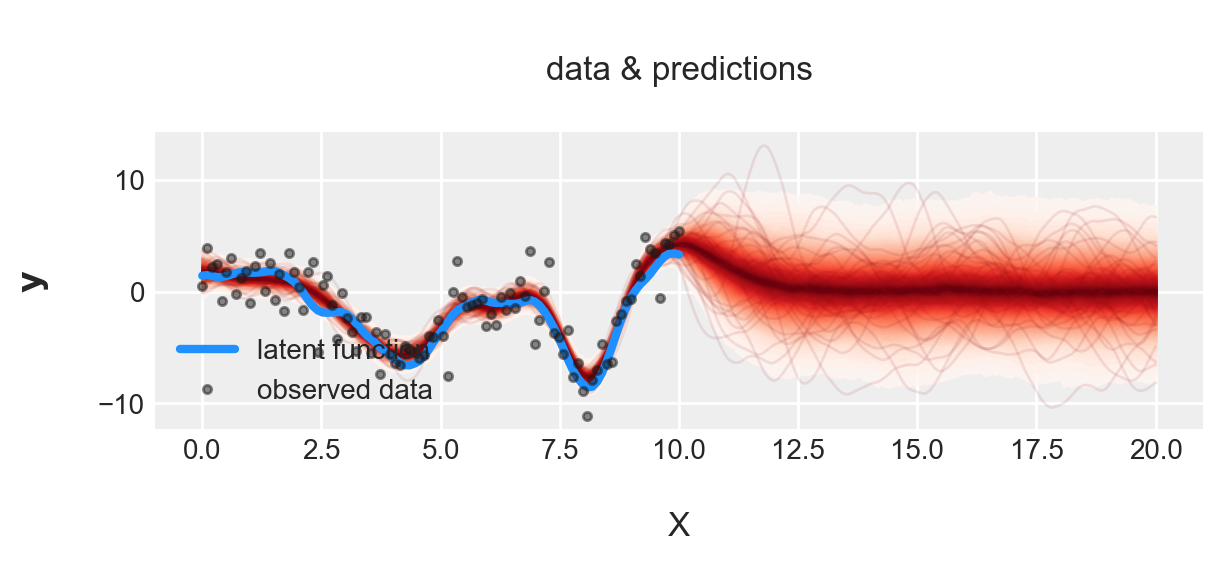

In [45]:
ax = relational.figure(width=6.0, height=2.7)

# Plotting the posterior predictive samples w.r.t. GP modelling & prediction
pm.gp.util.plot_gp_dist(ax=ax, samples=pred_samples['f_predictions'], x=X_new, plot_samples=True, palette='Reds')

# Plotting the simulated observed data and its latent function
ax.plot(X, f_true, 'dodgerblue', linewidth=3, label='latent function');
ax.plot(X, y, 'ok', markersize=3, alpha=0.5, label='observed data');

relational.annotation(handle=ax, 
                      labels=RelationalGraphLabels._make(['\ndata & predictions\n', '\nX', r'$\mathbf{y}$' + '\n']))

ax.legend(loc='lower left', fontsize='small');


<br>
<br>

### Case: MAP, incl. Noise

* `X_new` is a column vector of 600 elements, which leads to 600 predicted observations.  In the case of 2000 samples for predicting, 600 predicted observations are expected 2000 times. 

In [34]:
with model:
    f_pred_ = gp.conditional(name='f_predictions_', Xnew=X_new, pred_noise=True)
    pred_samples_ = pm.sample_posterior_predictive([maximal], vars=[f_pred_], samples=2000)
    
logger.info('\n{}\n'.format(pred_samples_['f_predictions_'].shape))

INFO:__main__:
(2000, 600)



<br>

* illustrate

In [35]:
index = np.random.randint(0, high=pred_samples_['f_predictions_'].shape[1], size=None)

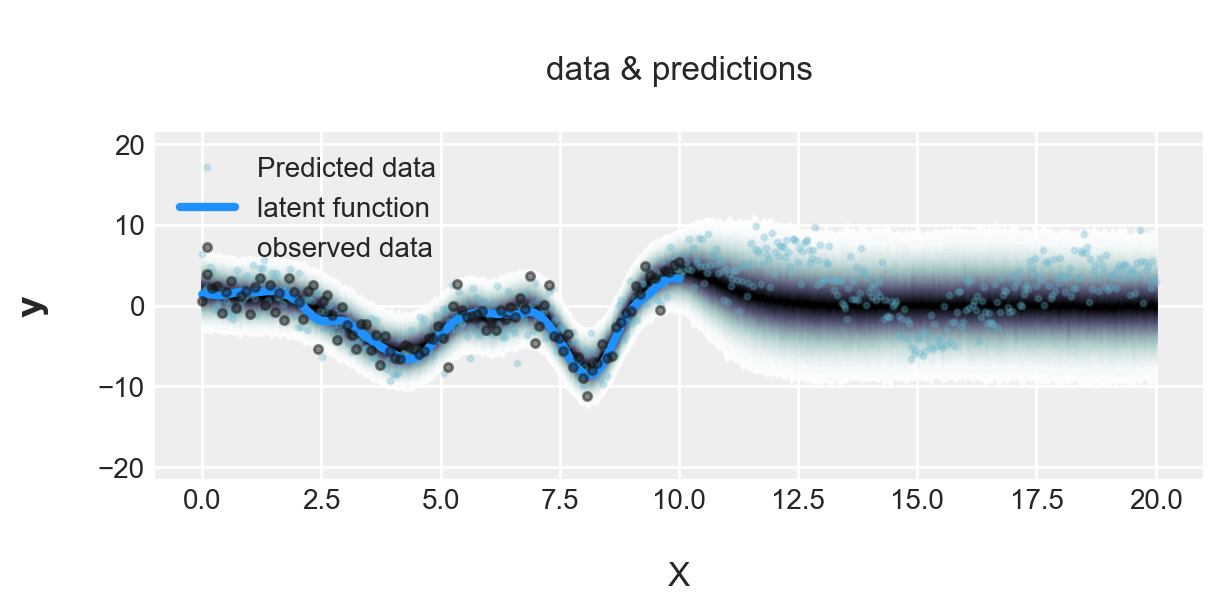

In [46]:
ax = relational.figure(width=6.0, height=2.95)

# Plotting the posterior predictive samples w.r.t. GP modelling & prediction
pm.gp.util.plot_gp_dist(ax=ax, samples=pred_samples_['f_predictions_'], x=X_new, plot_samples=False, palette='bone_r')

# Instead of a plot of the sample via .gp.util.plot_gp_dist(), overlay a scatter of one draw of random points from the
# posterior predictive distribution
ax.plot(X_new, pred_samples_['f_predictions_'][index, :].T, 'oc', markersize=2, alpha=0.25, label='Predicted data')

# Plotting the simulated observed data and its latent function
ax.plot(X, f_true, 'dodgerblue', linewidth=3, label='latent function');
ax.plot(X, y, 'ok', markersize=3, alpha=0.5, label='observed data');

ax.set_ylim(bottom=-21.5, top=21.5, auto=False)

relational.annotation(handle=ax, 
                      labels=RelationalGraphLabels._make(['\ndata & predictions\n', '\nX', r'$\mathbf{y}$' + '\n']))

ax.legend(loc='upper left', fontsize='small');


<br>
<br>

## via *.predict( )*

In [37]:
mu, var = gp.predict(X_new, point=maximal, diag=True, pred_noise=False)
sd = np.sqrt(var)

logger.info('\n{}\n'.format(mu.shape))
logger.info('\n{}\n'.format(sd.shape))

INFO:__main__:
(600,)

INFO:__main__:
(600,)



<br>

* illustrate

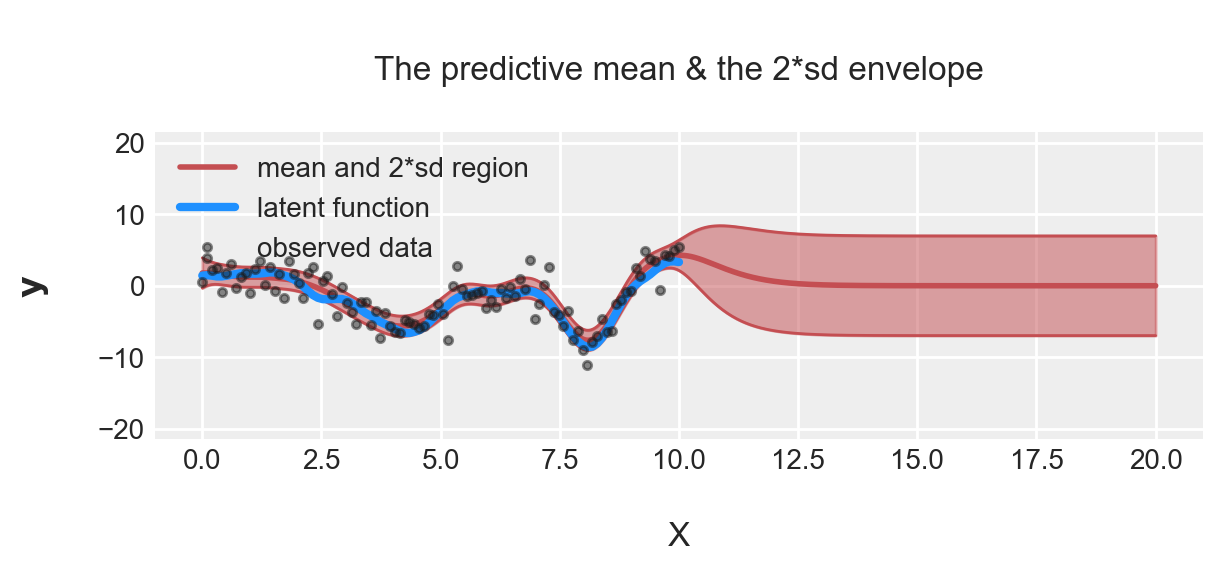

In [47]:
ax = relational.figure(width=6.0, height=2.75)


# The area -> mu - 2*sd ... mu + 2*sd
ax.plot(X_new, mu, 'r', linewidth=2, label='mean and 2*sd region')
ax.plot(X_new, mu + 2*sd, 'r', linewidth=1)
ax.plot(X_new, mu - 2*sd, 'r', linewidth=1)
ax.fill_between(X_new.flatten(), mu - 2*sd, mu + 2*sd, color='r', alpha=0.5)


# Plotting the simulated observed data and its latent function
ax.plot(X, f_true, 'dodgerblue', linewidth=3, label='latent function')
ax.plot(X, y, 'ok', markersize=3, alpha=0.5, label='observed data')

# Formatting
ax.set_ylim(bottom=-21.5, top=21.5, auto=False)

relational.annotation(handle=ax, 
                      labels=RelationalGraphLabels._make(['\nThe predictive mean & the 2*sd envelope\n', '\nX', r'$\mathbf{y}$' + '\n']))

ax.legend(loc='upper left', fontsize='small');
